In [2]:
import voxelwise_tutorials
from himalaya.ridge import RidgeCV
import numpy as np
from pathlib import Path
from AOTaccess.stimulus_info_access import StimuliInfoAccess
from AOTaccess.glmsingle_access import GLMSingleAccess
from AOTanalysis.bandedRR.construct_features import (
    construct_features_motion_energy,
    construct_features_sbert_embeddings,
    construct_features_sbert_embeddings_PCA,
)
from AOTanalysis.bandedRR.construct_target import (
    construct_target_data_split_flatten_masked,
)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from himalaya.backend import set_backend


from himalaya.kernel_ridge import MultipleKernelRidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.kernel_ridge import Kernelizer
from sklearn import set_config
from himalaya.kernel_ridge import ColumnKernelizer
from voxelwise_tutorials.utils import explainable_variance
from AOTanalysis.bandedRR.utils import split_single_array
from AOTglmsingle.glmoutput_save_nifti import get_affine_matrix
from AOTanalysis.bandedRR.utils import reshape_from_flatten_masked_to_wholebrain
from himalaya.scoring import r2_score

import os

import joblib
import nibabel as nib

# model_path = "/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature/model_sub1_split0_single_semantic.joblib"
# R2_file = "/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature/R2_score_single_sub1_train0_test1_fw.nii.gz"

model_path = "/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature/model_sub1_split0_splittotalnum_10_single_semantic.joblib"
R2_file = "/tank/shared/2024/visual/AOT/temp/bandedRR_split_single_feature/R2_score_single_sub1_semantic_train0_splittotalnum_10_test1_fw.nii.gz"

model = joblib.load(model_path)

glmsingle_access = GLMSingleAccess()
stimuli_info_access = StimuliInfoAccess()

sub = 1
n_splits = 10
# n_splits = 5
split_index_train = 0
#split_index_test = 1
split_index_test = 0
centered = True
direction = "fw"
randomize = True


def mask_construct(R2_file, threshold=0.1):
    R2 = nib.load(R2_file).get_fdata()
    mask = np.zeros_like(R2)
    mask[R2 > threshold] = 1
    return mask


test_video_betas, test_video_index = construct_target_data_split_flatten_masked(
    sub,
    n_splits,
    split_index_test,
    centered=centered,
    direction=direction,
    randomize=randomize,
)

print(f"Shape of test_video_betas: {test_video_betas.shape}")  # (360,641846)
len_test = test_video_betas.shape[0]
list_of_test_video_betas_glm = [test_video_betas[i] for i in range(len_test)]
list_of_test_video_betas_glm_wholebrain = [
    reshape_from_flatten_masked_to_wholebrain(list_of_test_video_betas_glm[i], sub)
    for i in range(len_test)
]
print(
    f"len of list_of_test_video_betas_wholebrain: {len(list_of_test_video_betas_glm_wholebrain)}"
)
print(
    f"Shape of list_of_test_video_betas_wholebrain[0]: {list_of_test_video_betas_glm_wholebrain[0].shape}"
)

test_X = construct_features_sbert_embeddings(test_video_index, centered=centered)
print(f"Shape of test_X: {test_X.shape}")

Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0001_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 1
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0002_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 2
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0003_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 3
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0004_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 4
Shape of betas: (2, 86, 104, 88)
Loaded beta from /tank/shared/2024/visual/AOT/derivatives/glmsingle/video_betas/sub-001/0005_fw_betas.nii
Shape of beta: (2, 86, 104, 88)
Loaded betas for video 5
Shape of betas: (2, 86, 104, 88)
Loaded beta from /ta

In [3]:
print(f"Shape of test_X: {test_X.shape}")
print(
    f"len of list_of_test_video_betas_glm_wholebrain: {len(list_of_test_video_betas_glm_wholebrain)}"
)
print(
    f"Shape of list_of_test_video_betas_glm_wholebrain[0]: {list_of_test_video_betas_glm_wholebrain[0].shape}"
)

Shape of test_X: (360, 768)
len of list_of_test_video_betas_glm_wholebrain: 360
Shape of list_of_test_video_betas_glm_wholebrain[0]: (86, 104, 88)


In [4]:
from himalaya.backend import set_backend

set_backend("torch_cuda", on_error="warn")
test_X = np.array(test_X)
model_predictions = model.predict(test_X)

print(f"Shape of model_predictions: {model_predictions.shape}")

Shape of model_predictions: torch.Size([360, 641846])


In [5]:
model_predictions = np.array(model_predictions)
print(f"Shape of model_predictions: {model_predictions.shape}")
len_test = model_predictions.shape[0]
list_of_model_predictions_wholebrain = [
    reshape_from_flatten_masked_to_wholebrain(model_predictions[i], sub)
    for i in range(len_test)
]
print(
    f"len of list_of_model_predictions_wholebrain: {len(list_of_model_predictions_wholebrain)}"
)


Shape of model_predictions: (360, 641846)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-001_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (86, 104, 88)
Shape of R2 mask: (86, 104, 88)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-001_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (86, 104, 88)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-001_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (86, 104, 88)
Shape of R2 mask: (86, 104, 88)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-001_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (86, 104, 88)
Loaded R2 from /tank/shared/2024/visual/AOT/derivatives/glmsingle/mainexp/sub-001_ses-01_T1W_nordicstc/TYPED_FITHRF_GLMDENOISE_RR/R2.nii
Shape of R2: (86, 104, 88)
Shape of R2 mask: (86, 104, 88)
Loaded R2 from /tank/shared/2024/visual/AO

In [6]:
def mask_and_flatten_list_of_data(list_of_data, mask):
    masked_data = [data[mask == 1] for data in list_of_data]
    flattened_masked_data = [data.flatten() for data in masked_data]
    return flattened_masked_data



In [7]:
prediction_R2_mask = mask_construct(R2_file)
print(f"Shape of prediction_R2_mask: {prediction_R2_mask.shape}")


flatten_and_masked_model_predictions = mask_and_flatten_list_of_data(
    list_of_model_predictions_wholebrain, prediction_R2_mask
)

flatten_and_masked_test_video_betas_glm = mask_and_flatten_list_of_data(
    list_of_test_video_betas_glm_wholebrain, prediction_R2_mask
)

print(
    f"Shape of flatten_and_masked_model_predictions: {flatten_and_masked_model_predictions[0].shape}"
)

print(
    f"Shape of flatten_and_masked_test_video_betas_glm: {flatten_and_masked_test_video_betas_glm[0].shape}"
)   



Shape of prediction_R2_mask: (86, 104, 88)
Shape of flatten_and_masked_model_predictions: (389,)
Shape of flatten_and_masked_test_video_betas_glm: (389,)


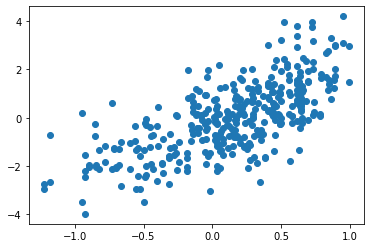

In [8]:
import seaborn as sns
# sns.heatmap(flatten_and_masked_model_predictions)
import matplotlib.pyplot as plt
plt.plot(
    np.array(flatten_and_masked_model_predictions).mean(1),
    np.array(flatten_and_masked_test_video_betas_glm).mean(1),
    "o",
)

In [9]:
# for each prediction, get the most similar betas
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import cosine_distances


def get_most_similar_beta(prediction, betas,metric_func=cosine_similarity):
    similarity = metric_func([prediction], betas)
    most_similar_index = np.argmax(similarity)
    return most_similar_index


most_similar_betas = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas: {len(most_similar_betas)}")
print(f"most_similar_betas: {most_similar_betas}")


# pearsonr from sklearn


most_similar_betas_euclidean = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=euclidean_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_euclidean: {len(most_similar_betas_euclidean)}")
print(f"most_similar_betas_euclidean: {most_similar_betas_euclidean}")

most_similar_betas_manhattan = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=manhattan_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_manhattan: {len(most_similar_betas_manhattan)}")
print(f"most_similar_betas_manhattan: {most_similar_betas_manhattan}")

most_similar_betas_cosine = [get_most_similar_beta(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm,metric_func=cosine_distances) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_cosine: {len(most_similar_betas_cosine)}")
print(f"most_similar_betas_cosine: {most_similar_betas_cosine}")




Shape of most_similar_betas: 360
most_similar_betas: [152, 152, 106, 106, 16, 16, 7, 7, 16, 16, 10, 10, 206, 206, 206, 206, 16, 16, 175, 175, 244, 244, 16, 16, 175, 175, 345, 345, 148, 148, 163, 163, 345, 345, 185, 185, 139, 139, 206, 206, 42, 42, 43, 43, 44, 44, 343, 343, 345, 345, 244, 244, 52, 52, 200, 200, 162, 162, 16, 16, 215, 215, 81, 81, 199, 199, 67, 67, 228, 228, 128, 128, 340, 340, 74, 74, 340, 340, 79, 79, 233, 233, 21, 21, 43, 43, 199, 199, 278, 278, 233, 233, 304, 304, 233, 233, 185, 185, 16, 16, 215, 215, 16, 16, 249, 249, 106, 106, 16, 16, 16, 16, 163, 163, 228, 228, 187, 187, 206, 206, 152, 152, 185, 185, 185, 185, 16, 16, 128, 128, 206, 206, 339, 339, 334, 334, 163, 163, 233, 233, 345, 345, 163, 163, 233, 233, 146, 146, 206, 206, 198, 198, 185, 185, 146, 146, 200, 200, 301, 301, 101, 101, 162, 162, 165, 165, 139, 139, 66, 66, 128, 128, 16, 16, 43, 43, 206, 206, 16, 16, 343, 343, 344, 344, 185, 185, 187, 187, 185, 185, 199, 199, 200, 200, 139, 139, 340, 340, 199, 199, 

In [10]:
from scipy.stats import pearsonr


def scores_for_a_prediction(prediction,betas):
    scores = [pearsonr(prediction,beta)[0] for beta in betas]
    return scores


def get_most_similar_beta_corr(prediction, betas):
    scores = scores_for_a_prediction(prediction,betas)
    most_similar_index = np.argmax(scores)
    return most_similar_index

most_similar_betas_corr = [get_most_similar_beta_corr(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]
print(f"Shape of most_similar_betas_corr: {len(most_similar_betas_corr)}")
print(f"most_similar_betas_corr: {most_similar_betas_corr}")

Shape of most_similar_betas_corr: 360
most_similar_betas_corr: [152, 152, 106, 106, 16, 16, 7, 7, 16, 16, 11, 11, 147, 147, 206, 206, 16, 16, 43, 43, 185, 185, 16, 16, 313, 313, 345, 345, 148, 148, 163, 163, 200, 200, 185, 185, 233, 233, 39, 39, 41, 41, 43, 43, 334, 334, 343, 343, 200, 200, 244, 244, 185, 185, 200, 200, 241, 241, 16, 16, 139, 139, 81, 81, 16, 16, 67, 67, 228, 228, 128, 128, 146, 146, 81, 81, 139, 139, 79, 79, 185, 185, 82, 82, 206, 206, 308, 308, 88, 88, 233, 233, 185, 185, 233, 233, 185, 185, 16, 16, 215, 215, 16, 16, 249, 249, 106, 106, 16, 16, 111, 111, 16, 16, 139, 139, 187, 187, 206, 206, 152, 152, 185, 185, 185, 185, 16, 16, 128, 128, 206, 206, 316, 316, 13, 13, 206, 206, 139, 139, 200, 200, 152, 152, 233, 233, 146, 146, 206, 206, 151, 151, 185, 185, 233, 233, 200, 200, 139, 139, 100, 100, 162, 162, 185, 185, 233, 233, 66, 66, 128, 128, 16, 16, 175, 175, 334, 334, 16, 16, 181, 181, 16, 16, 185, 185, 187, 187, 185, 185, 171, 171, 200, 200, 139, 139, 301, 301, 199,

Shape of similarity_matrix: (360, 360)


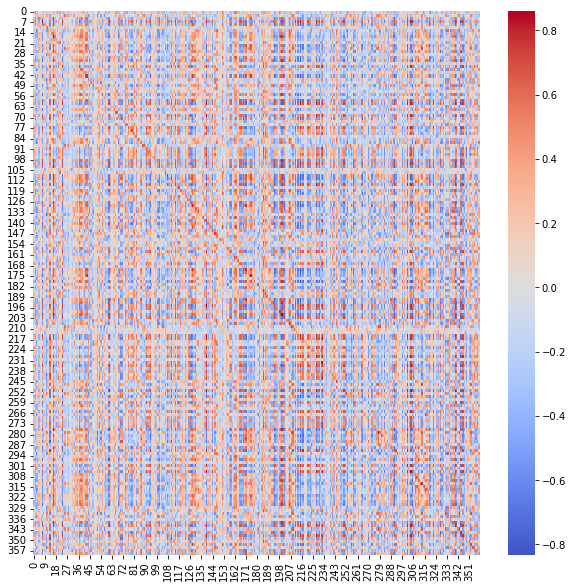

In [11]:
# draw a picture to show the similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

similarity_matrix = [scores_for_a_prediction(flatten_and_masked_model_predictions[i], flatten_and_masked_test_video_betas_glm) for i in range(len(flatten_and_masked_model_predictions))]

similarity_matrix = similarity_matrix
similarity_matrix = np.array(similarity_matrix)



print(f"Shape of similarity_matrix: {similarity_matrix.shape}")
plt.figure(figsize=(10, 10))
sns.heatmap(similarity_matrix, cmap="coolwarm", center=0)
plt.show()